# MVP 

## Minimum Viable Project

The simplest start is the training and testing subset provided by the 
dataset author.

The simplest algorithm is one-nearest-neighbor: Tag the 
values of the testing set with the label that their nearest neighbor in
the training set has.


## Library imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

In [2]:
%load_ext watermark
%watermark -iv

matplotlib 3.0.2
pandas     0.24.0
numpy      1.15.4
tqdm       4.31.1
seaborn    0.9.0



In [3]:
%matplotlib inline

## Connect to Postgres

And the training subset is small enough to load into Pandas.

In [4]:
%load_ext sql
%config SqlMagic.autopandas = True
%sql postgres://localhost/nb15

'Connected: @nb15'

In [5]:
trainset = %sql select * from trainset;
trainset.shape

 * postgres://localhost/nb15
175341 rows affected.


(175341, 45)

In [6]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
id                   175341 non-null int64
dur                  175341 non-null float64
proto                175341 non-null object
service              175341 non-null object
state                175341 non-null object
spkts                175341 non-null int64
dpkts                175341 non-null int64
sbytes               175341 non-null int64
dbytes               175341 non-null int64
rate                 175341 non-null float64
sttl                 175341 non-null int64
dttl                 175341 non-null int64
sload                175341 non-null float64
dload                175341 non-null float64
sloss                175341 non-null int64
dloss                175341 non-null int64
sinpkt               175341 non-null float64
dinpkt               175341 non-null float64
sjit                 175341 non-null float64
djit                 175341 non-null float64
swin      

In [7]:
testset = %sql select * from testset;
testset.shape

 * postgres://localhost/nb15
82332 rows affected.


(82332, 45)

## Feature selection and engineering

In [8]:
normset = trainset.query('label == 0')
attackset = trainset.query('label == 1')
attackgroup = trainset.groupby('attack_cat')

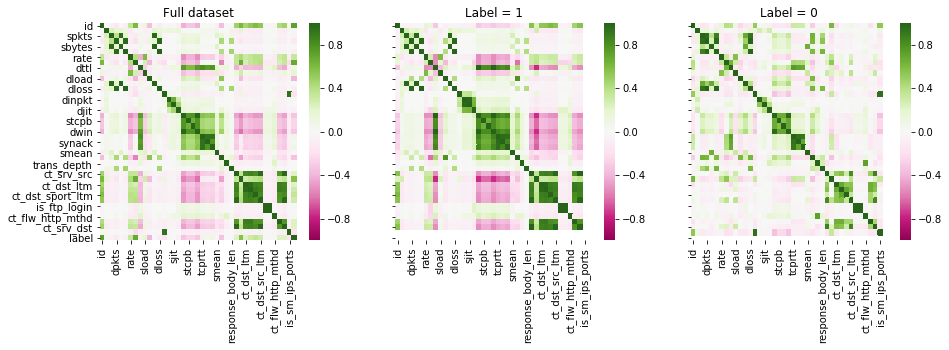

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,4))

corrdata = trainset.corr()
sns.heatmap(corrdata, ax=axs[0], vmin=-1, vmax=1, cmap='PiYG')
axs[0].set_title('Full dataset')

corrdata = attackset.corr()
sns.heatmap(corrdata, ax=axs[1], vmin=-1, vmax=1, cmap='PiYG')
axs[1].set_title('Label = 1')

corrdata = normset.corr()
sns.heatmap(corrdata, ax = axs[2], vmin=-1, vmax=1, cmap='PiYG')
axs[2].set_title('Label = 0')

plt.show()

Looks like we have some correlated columns to clean up, but a lot of white means there are
plenty of columns that are uncorrelated.

And, it looks like we have a few good candidates for feature selection looking  at the difference between the two correlation maps for the attack and normal
labels.

In [10]:
corrdata = trainset.corr()

# we're not going to model on row-id or our target! 
corrdata = corrdata.drop(columns='id')
corrdata = corrdata.drop(index='id')
corrdata = corrdata.drop(index='label')
corrdata = corrdata.drop(columns='label')

for r, row in enumerate(corrdata.index):
    for c, col in enumerate(corrdata.columns):
        if r < c:
            abc = abs(corrdata.loc[row,col])
            if abc > .5:
                print(row, col, corrdata.loc[row,col])
        

spkts sbytes 0.9637905453632948
spkts sloss 0.9710686917734201
dpkts dbytes 0.9719070079937576
dpkts dloss 0.9786363765707413
sbytes sloss 0.9961094729162718
dbytes dloss 0.9965035947658807
rate sload 0.6024917209485852
rate swin -0.515680523970463
rate dwin -0.5181167101716453
sttl dmean -0.5503894995831023
sttl ct_state_ttl 0.6723247538872464
dttl swin 0.746246550391458
dttl stcpb 0.5927892500491115
dttl dtcpb 0.5967704444222411
dttl dwin 0.7540175796120973
dttl tcprtt 0.8073405596741321
dttl synack 0.7469996936389071
dttl ackdat 0.781261466971933
dload dmean 0.550601586510385
sinpkt is_sm_ips_ports 0.9413189007356698
dinpkt sjit 0.6731042707786768
swin stcpb 0.7812149404258413
swin dtcpb 0.7816351259976572
swin dwin 0.9901399299450626
swin tcprtt 0.5697518462385165
swin synack 0.52896194809928
swin ackdat 0.5494258227235498
swin ct_state_ttl -0.5575336991045338
stcpb dtcpb 0.6498790909569351
stcpb dwin 0.7888342470350359
dtcpb dwin 0.7893866556371264
dwin tcprtt 0.5754476712726219
d

### whoa that 1.0 correlation looks really weird

In [11]:
trainset.ct_ftp_cmd.value_counts()

0    172774
1      2545
4        16
2         6
Name: ct_ftp_cmd, dtype: int64

In [12]:
trainset.is_ftp_login.value_counts()

0    172774
1      2545
4        16
2         6
Name: is_ftp_login, dtype: int64

In [13]:
# looks like these are really exactly the same 
# so drop one 
corrdata = corrdata.drop(columns='is_ftp_login')
corrdata = corrdata.drop(index='is_ftp_login')

In [14]:
corrdata.index

Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports'],
      dtype='object')

In [15]:
# make some kde plots
len(corrdata.index)

38

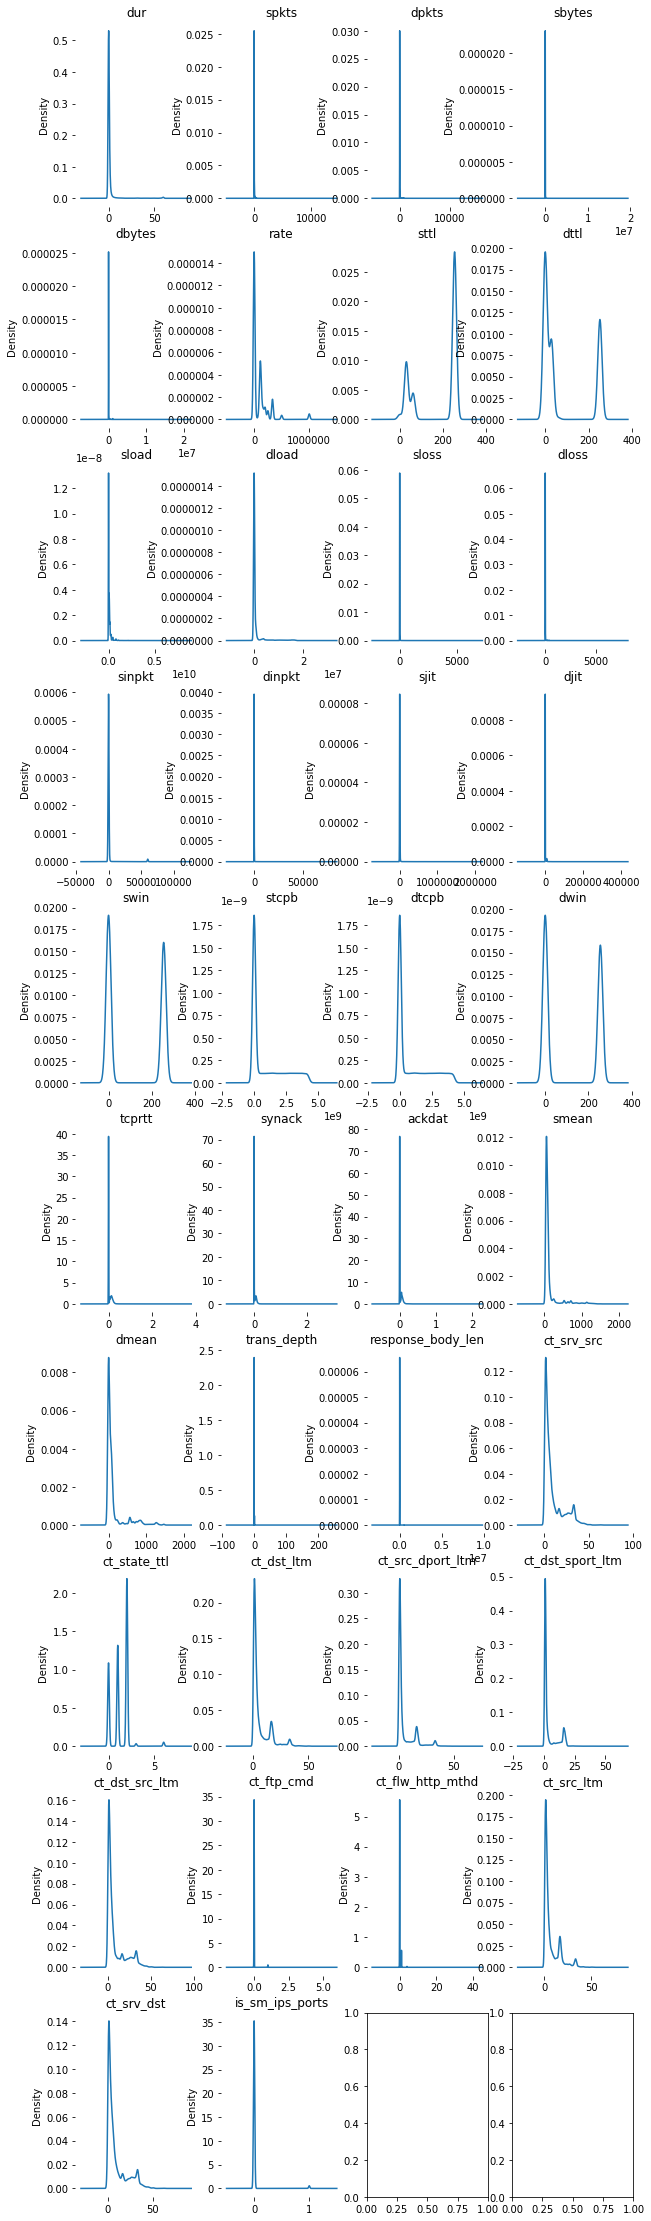

In [16]:
fig, axs = plt.subplots(nrows=10, ncols=4, figsize=(10,40) )
for i,label in enumerate(corrdata.index):
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    trainset[label].plot.kde(ax=ax)
    ax.set_title(label)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

### Normalization -- 
We have a lot of poission arrival type data here. It seems like a good 
candidate for log and robust scaling but let's check

38it [02:54,  4.93s/it]


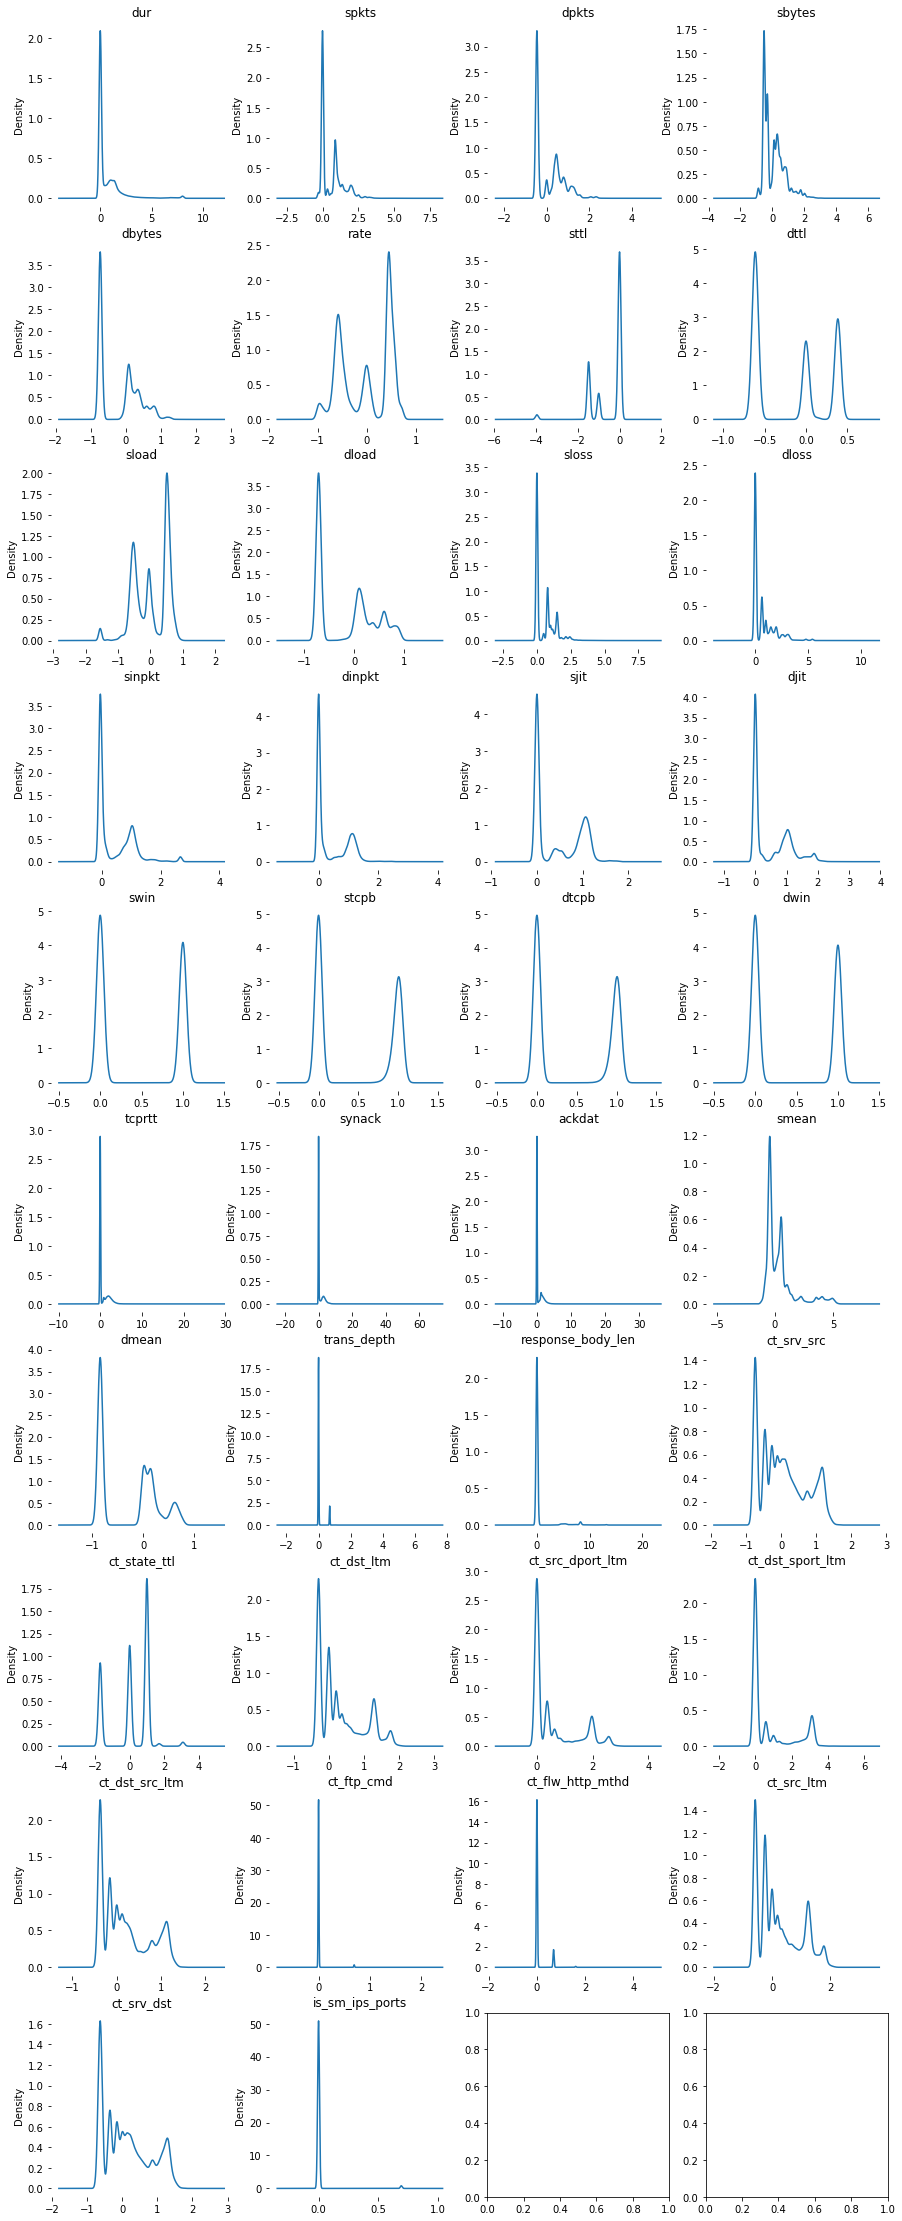

In [17]:
l1p = FunctionTransformer(np.log1p, np.expm1, validate=False)
rsc = RobustScaler()
xform = make_pipeline(l1p, rsc)

fig, axs = plt.subplots(nrows=10, ncols=4, figsize=(15,40) )
for i,label in tqdm.tqdm(enumerate(corrdata.index)):
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    data = xform.fit_transform(
                    trainset[label].values.reshape(-1,1)
                )
    slabel = pd.Series(
        data.reshape(-1)
    )
    slabel.plot.kde(ax=ax)
    ax.set_title(label)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

In [18]:
## looks like is_sm_ips_ports is really categorical

trainset.is_sm_ips_ports.value_counts()

0    172579
1      2762
Name: is_sm_ips_ports, dtype: int64

In [19]:
corrdata = corrdata.drop(index='is_sm_ips_ports')
corrdata = corrdata.drop(columns='is_sm_ips_ports')
corrdata.index

Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst'],
      dtype='object')

In [20]:
final_list_numeric_cols = corrdata.index
trainset[final_list_numeric_cols].shape

(175341, 37)

In [21]:
xformed_data = xform.fit_transform(trainset[final_list_numeric_cols].values)
xformed_data = pd.DataFrame(data=xformed_data, columns=final_list_numeric_cols)
xformed_data.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst
0,0.220981,0.577833,0.213031,-0.202676,0.006758,-0.457714,-0.005632,0.386755,-0.467837,0.172891,...,-0.749222,-1.709511,-0.292481,0.00000,0.0,-0.370310,0.000000,0.0,-0.575717,-0.624884
1,0.975524,1.097591,1.069667,0.212419,0.790751,-0.450805,-1.000000,0.385332,-0.527053,0.571749,...,1.358780,0.000000,-0.292481,0.00000,0.0,-0.153693,0.000000,0.0,-0.575717,0.229464
2,1.881698,0.749222,0.723385,-0.066146,0.625346,-0.652373,-1.000000,0.385332,-0.716789,0.365387,...,0.196191,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,-0.238944,0.229464
3,1.924816,1.000000,0.611510,0.150440,0.220067,-0.656395,-1.000000,0.385332,-0.653881,0.082235,...,-0.749222,0.000000,0.000000,0.00000,0.0,0.000000,0.693147,0.0,-0.238944,-0.624884
4,0.722369,0.886074,0.353351,0.086024,0.069766,-0.552816,0.000000,0.385332,-0.524830,0.098990,...,1.358780,0.000000,0.000000,0.36907,0.0,1.243335,0.000000,0.0,-0.238944,1.418120


In [22]:
xformed_test_data = xform.transform(testset[final_list_numeric_cols].values)
xformed_test_data = pd.DataFrame(data=xformed_test_data, 
                                 columns=final_list_numeric_cols)
xformed_test_data.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst
0,-0.003068,0.0,-0.458157,0.056703,-0.728818,0.406325,0.0,-0.614668,0.603123,-0.711124,...,-0.472707,1.0,-0.292481,0.00000,0.0,-0.153693,0.0,0.0,-0.575717,-0.348368
1,-0.003074,0.0,-0.458157,0.560601,-0.728818,0.445085,0.0,-0.614668,0.782828,-0.711124,...,-0.472707,1.0,-0.292481,0.00000,0.0,-0.153693,0.0,0.0,-0.575717,-0.348368
2,-0.003080,0.0,-0.458157,0.361501,-0.728818,0.502290,0.0,-0.614668,0.779355,-0.711124,...,-0.276516,1.0,-0.292481,0.00000,0.0,0.000000,0.0,0.0,-0.575717,-0.152178
3,-0.003078,0.0,-0.458157,0.293459,-0.728818,0.480099,0.0,-0.614668,0.739306,-0.711124,...,-0.276516,1.0,0.000000,0.36907,0.0,0.000000,0.0,0.0,-0.238944,-0.152178
4,-0.003070,0.0,-0.458157,0.635297,-0.728818,0.417926,0.0,-0.614668,0.778823,-0.711124,...,-0.276516,1.0,0.000000,0.36907,0.0,0.000000,0.0,0.0,-0.238944,-0.152178


## Categorical values

We need to process the train and test sets simultaneously here, so that the one
hot vectors turn out the same. 

### Combine infrequent values of proto into one category other

In [23]:
trainset.proto.value_counts()

tcp            79946
udp            63283
unas           12084
arp             2859
ospf            2595
sctp            1150
any              300
gre              225
pim              201
swipe            201
ipv6             201
sun-nd           201
mobile           201
rsvp             200
sep              193
ib               101
pgm              100
pnni             100
gmtp             100
idpr-cmtp        100
etherip          100
nsfnet-igp       100
fire             100
micp             100
iso-ip           100
srp              100
ipip             100
pri-enc          100
ipv6-opts        100
compaq-peer      100
               ...  
xns-idp           99
igp               99
nvp               99
leaf-1            99
dcn               99
trunk-2           99
emcon             99
ggp               99
iso-tp4           99
cbt               99
crtp              99
mux               99
leaf-2            99
ip                99
st2               99
irtp              99
xnet         

In [24]:
# m_ just means my modified version 
trainset['m_proto'] = trainset['proto']
testset['m_proto'] = testset['proto']

val_counts = trainset.proto.value_counts()
common_proto = list(val_counts[val_counts > 1000].index)

query_string = "proto != '" + "'"" and proto != '".join(common_proto) + "'"
query_string

"proto != 'tcp' and proto != 'udp' and proto != 'unas' and proto != 'arp' and proto != 'ospf' and proto != 'sctp'"

In [25]:
trainset.loc[trainset.eval(query_string), 'm_proto'] = 'other'
testset.loc[testset.eval(query_string), 'm_proto'] = 'other'

trainset.m_proto.value_counts()

tcp      79946
udp      63283
other    13424
unas     12084
arp       2859
ospf      2595
sctp      1150
Name: m_proto, dtype: int64

### Combine infrequent values of service into one category other

Also renaming the '-' value to 'none'

In [26]:
trainset.service.value_counts()

-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
ssl            56
irc            25
radius         12
Name: service, dtype: int64

In [27]:
trainset['m_service'] = trainset['service']
trainset.loc[trainset.eval("service == '-'"), 'm_service'] = 'none'

testset['m_service'] = testset['service']
testset.loc[testset.eval("service == '-'"), 'm_service'] = 'none'

val_counts = trainset.m_service.value_counts()
common_service = list(val_counts[val_counts > 1000].index)
query_string = "m_service != '" + "'"" and m_service != '".join(common_service) + "'"
query_string

"m_service != 'none' and m_service != 'dns' and m_service != 'http' and m_service != 'smtp' and m_service != 'ftp-data' and m_service != 'ftp' and m_service != 'ssh' and m_service != 'pop3'"

In [28]:
trainset.loc[trainset.eval(query_string), 'm_service'] = 'other'
testset.loc[testset.eval(query_string), 'm_service'] = 'other'

trainset.m_service.value_counts()

none        94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
other         267
Name: m_service, dtype: int64

### Combine infrequent values of state into one category other

In [29]:
trainset.state.value_counts()

INT    82275
FIN    77825
CON    13152
REQ     1991
RST       83
ECO       12
URN        1
PAR        1
no         1
Name: state, dtype: int64

In [30]:
trainset['m_state'] = trainset['state']
testset['m_state'] = testset['state']

val_counts = trainset.state.value_counts()
common_state = list(val_counts[val_counts > 1000].index)
query_string = "state != '" + "'"" and state != '".join(common_state) + "'"
query_string

"state != 'INT' and state != 'FIN' and state != 'CON' and state != 'REQ'"

In [31]:
trainset.loc[trainset.eval(query_string), 'm_state'] = 'other'
testset.loc[testset.eval(query_string), 'm_state'] = 'other'

trainset.m_state.value_counts()

INT      82275
FIN      77825
CON      13152
REQ       1991
other       98
Name: m_state, dtype: int64

## Create dummy variables 

In [32]:
dummies = pd.get_dummies(trainset[['m_proto', 'm_state', 'm_service']])
test_dummies = pd.get_dummies(testset[['m_proto', 'm_state', 'm_service']])

# rather than dropping the first, I'm dropping the 'catch-all' column 
dummies = dummies.drop(columns=['m_proto_other', 'm_state_other', 'm_service_other'])
dummies.columns = [ s.replace('m_','') for s in dummies.columns ]

test_dummies = test_dummies.drop(columns=['m_proto_other', 'm_state_other', 'm_service_other'])
test_dummies.columns = [ s.replace('m_','') for s in dummies.columns ]

In [33]:
dummies.head(5)

,proto_arp,proto_ospf,proto_sctp,proto_tcp,proto_udp,proto_unas,state_CON,state_FIN,state_INT,state_REQ,service_dns,service_ftp,service_ftp-data,service_http,service_none,service_pop3,service_smtp,service_ssh
0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [34]:
test_dummies.head(5)

,proto_arp,proto_ospf,proto_sctp,proto_tcp,proto_udp,proto_unas,state_CON,state_FIN,state_INT,state_REQ,service_dns,service_ftp,service_ftp-data,service_http,service_none,service_pop3,service_smtp,service_ssh
0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0


In [35]:
test_dummies.columns

Index(['proto_arp', 'proto_ospf', 'proto_sctp', 'proto_tcp', 'proto_udp',
       'proto_unas', 'state_CON', 'state_FIN', 'state_INT', 'state_REQ',
       'service_dns', 'service_ftp', 'service_ftp-data', 'service_http',
       'service_none', 'service_pop3', 'service_smtp', 'service_ssh'],
      dtype='object')

In [36]:
dummies.columns

Index(['proto_arp', 'proto_ospf', 'proto_sctp', 'proto_tcp', 'proto_udp',
       'proto_unas', 'state_CON', 'state_FIN', 'state_INT', 'state_REQ',
       'service_dns', 'service_ftp', 'service_ftp-data', 'service_http',
       'service_none', 'service_pop3', 'service_smtp', 'service_ssh'],
      dtype='object')

In [37]:
# Yay! Both tables have the columns in the same order!

# KNN-1 as the baseline model

KNN-1 is just taking a vector from the testing set, finding the 
calculating a single nearest neighbor point from the training set,
and giving the previously-unseen data the same label.

It's a good baseline model because it's fairly simple, yet has predicted
well on similar datasets in the past.

I'm going to do this twice: Once with the up/down label and once with the 
specific attack categories.

In [38]:
## Pull all the stuff together

prepped_data = pd.concat([dummies, trainset.is_sm_ips_ports, xformed_data],
                    axis=1)

prepped_test_data = pd.concat([test_dummies, testset.is_sm_ips_ports, xformed_test_data],
                             axis=1)

In [39]:
prepped_data.shape

(175341, 56)

In [40]:
prepped_test_data.shape

(82332, 56)

In [41]:
knn1 = KNeighborsClassifier(n_neighbors=1)

In [42]:
X = prepped_data.values
y = trainset.label

In [43]:
knn1.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [49]:
test_predictions = knn1.predict(prepped_test_data.values)

In [50]:
# Now to figure out my confusion matrix
y_gt = testset.label

In [51]:
confusion_matrix(y_gt, test_predictions)

array([[27732,  9268],
       [ 2066, 43266]])

In [52]:
print(classification_report(y_gt, test_predictions))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83     37000
           1       0.82      0.95      0.88     45332

   micro avg       0.86      0.86      0.86     82332
   macro avg       0.88      0.85      0.86     82332
weighted avg       0.87      0.86      0.86     82332



In [53]:
roc_auc_score(y_gt, test_predictions)

0.8519693218322002

In [54]:
accuracy_score(y_gt, test_predictions)

0.8623378516251275

In [55]:
# So those are the scores for my models to beat! 
# 95% recall doesn't seem like a bad start


In [56]:
attack_types = trainset.attack_cat.unique()

In [57]:
ordinal_encoder = dict()
for i,name in enumerate(attack_types):
    ordinal_encoder[name] = i
    
y = trainset.attack_cat.map(ordinal_encoder)
y_gt = testset.attack_cat.map(ordinal_encoder)


In [58]:
knn1.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [59]:
y_pred = knn1.predict(prepped_test_data.values)

In [60]:
print(confusion_matrix(y_gt, y_pred))

[[27732     8   653  6953   158   524   765   157     2    48]
 [    5    71   100    37     3    28   196   142     0     1]
 [    6   131    99    57     0    20   209   154     0     1]
 [ 1586   229   239  2893    55   207   531   309     4     9]
 [   20     3     0    46   194    46    47    17     1     4]
 [   67   146    63   110    46  2686   300    72     0     6]
 [  277  1100   639   523   100   401  6988  1014    18    72]
 [   72  1115   565   206    36   136   981   951     0    27]
 [    2     0     0     3     1     1    28     1     7     1]
 [   31     3     6    66    13    22   304   100     4 18322]]


In [61]:
print(classification_report(y_gt, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83     37000
           1       0.03      0.12      0.04       583
           2       0.04      0.15      0.07       677
           3       0.27      0.48      0.34      6062
           4       0.32      0.51      0.39       378
           5       0.66      0.77      0.71      3496
           6       0.68      0.63      0.65     11132
           7       0.33      0.23      0.27      4089
           8       0.19      0.16      0.18        44
           9       0.99      0.97      0.98     18871

   micro avg       0.73      0.73      0.73     82332
   macro avg       0.44      0.48      0.45     82332
weighted avg       0.80      0.73      0.76     82332



In [62]:
list(enumerate(attack_types))

[(0, 'Normal'),
 (1, 'Backdoor'),
 (2, 'Analysis'),
 (3, 'Fuzzers'),
 (4, 'Shellcode'),
 (5, 'Reconnaissance'),
 (6, 'Exploits'),
 (7, 'DoS'),
 (8, 'Worms'),
 (9, 'Generic')]

Lots of room for improvement on the second-level task. We recognized normal
traffic and generic bad packets very well, but quite a bit of room for improvement elsewhere. You can also see in the 'support' column of the classification report the imbalanced learning challenges in this problem set.

In [63]:
accuracy_score(y_gt, y_pred)

0.7280644220959044